In [ ]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [2]:
subjects=[1]
n_subjects = len(subjects)

noise_level = 0.10

trial_subsets = ['all',\
                 'balance_indoor_outdoor','outdoor_only','indoor_only',\
                 'balance_animacy', 'animate_only', 'inanimate_only',\
                 'balance_real_world_size_binary','large_only', 'small_only']

n_trial_subsets = len(trial_subsets)

fitting_types = ['gabor_solo_ridge_12ori_8sf_%s_simulated_gabor_addnoise_0.10'%ts for ts in trial_subsets]
fitting_types[0] = 'gabor_solo_ridge_12ori_8sf_simulated_gabor_addnoise_0.10'

out = [[load_fits.load_fit_results(subject=ss, fitting_type=ft, n_from_end=0, \
                                  verbose=False) for ss in subjects] for ft in fitting_types]


#### load the ground-truth feature prefs of the simulated voxels

In [3]:
thing = '/user_data/mmhender/features/gabor_texture/simulated_data/S1_sim_data_addnoise_0.10.npy'
sim = np.load(thing, allow_pickle=True).item()
sim_prf_inds = sim['simulated_voxel_prf_inds']
assert(np.all(out[0][0]['best_params'][5][:,0]==sim_prf_inds))
sim_orient = sim['simulated_voxel_orient']
sim_sf = sim['simulated_voxel_sf']
un, sim_sf_inds = np.unique(sim_sf, return_inverse=True)
prf_pars = out[0][0]['models'][sim_prf_inds,:].round(2)

In [38]:
np.unique(sim_prf_inds).shape

(160,)

In [39]:
160/8

20.0

In [40]:
160*96

15360

#### Get info about the Gabor feature space

In [4]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


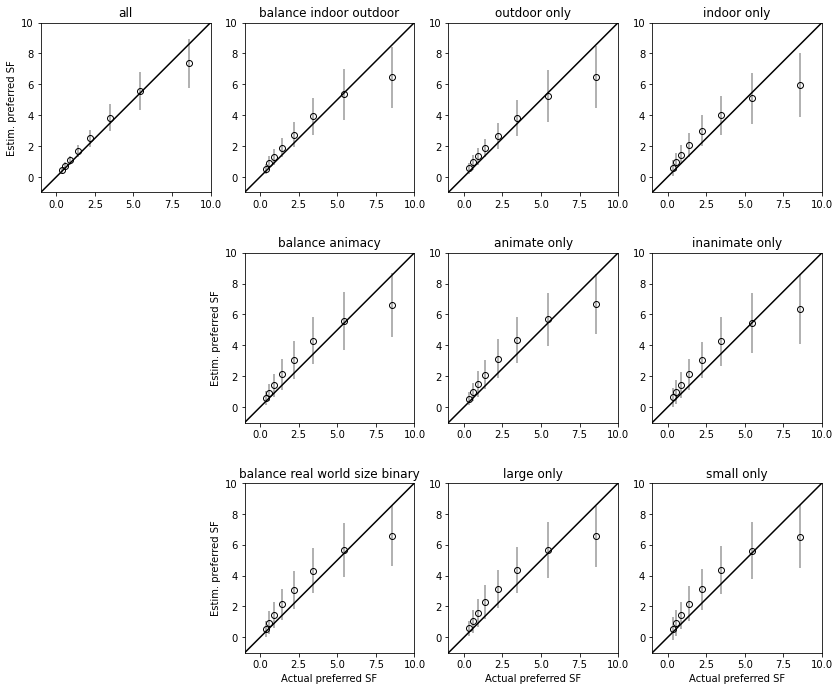

In [34]:
from utils import numpy_utils
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,12))
pi=0;
    
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
    
    est_sf = np.array(sf_unique)[preferred_sf_corr.astype(int)]
    
    
    x,y = sim_sf, est_sf
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x,y, n_bins=len(np.unique(x)),\
                                                            use_unique=True, linear_bins=False,\
                                                            return_std=True)
    pi+=1
    plt.subplot(3,4,pi)
    plt.plot(xbinned, ybinned, 'o',markerfacecolor='none',color='k')
    plt.errorbar(xbinned,ybinned, ystd, linestyle='none',color=[0.6, 0.6, 0.6])
    # plt.plot( x,y, '.',alpha=0.2)
    # plt.xticks(np.arange(0,180,45))
    # plt.yticks(np.arange(0,180,45))
    plt.axis('square')
    lims = [-1, 10]
    # lims = [-5, 180]
    plt.plot(lims, lims, color='k')
    plt.xlim(lims)
    plt.ylim(lims)
    # plt.title('prf size=%.2f'%(size*8.4))
    if pi>9:
        plt.xlabel('Actual preferred SF')
    if pi in [1,6,10]:
        plt.ylabel('Estim. preferred SF')

    plt.title('%s'%trial_subset.replace('_',' '))
    
    if np.mod(pi,4)==0:
        pi+=1
        
fn2save = os.path.join(default_paths.fig_path,'Simulation_estim_freq_prefs.pdf')
plt.savefig(fn2save)

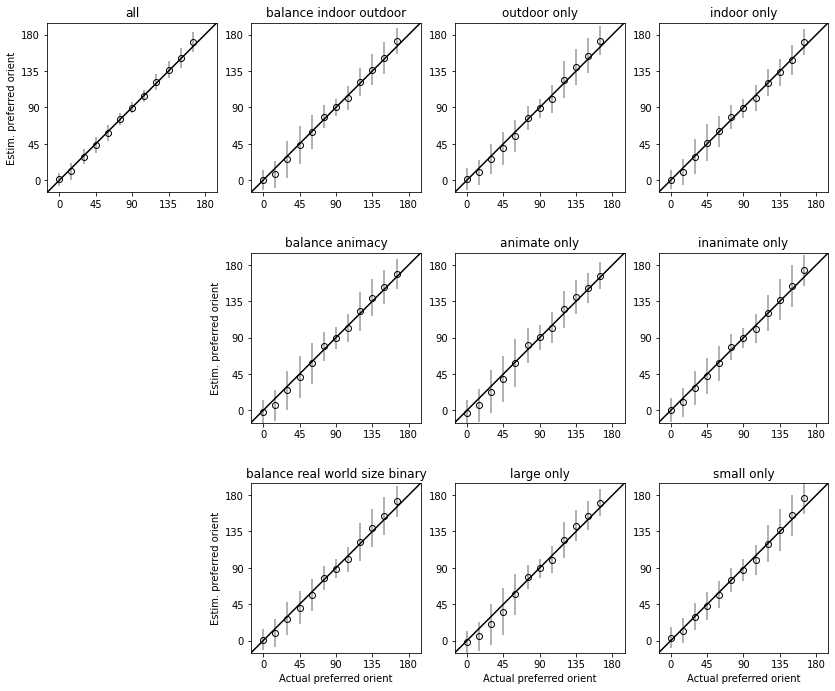

In [35]:
from utils import numpy_utils
plt.rcParams['pdf.fonttype']=42

import scipy.stats

plt.figure(figsize=(14,12))
pi=0;

for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

   
    est_orient = np.array(ori_unique)[preferred_ori_corr.astype(int)]
    
    x,y = sim_orient, est_orient
    xbinned = np.unique(x)
    ybinned = np.array([scipy.stats.circmean(y[x==xb], high=180,low=0) for xb in xbinned])
    ystd = np.array([scipy.stats.circstd(y[x==xb], high=180,low=0) for xb in xbinned])

    # since the space is circular, wrapping some of the points by 180 to make easier to see trend
    ybinned[(ybinned>177)] = ybinned[(ybinned>177)]-180
    
    pi+=1
    plt.subplot(3,4,pi)
    plt.plot(xbinned, ybinned, 'o',color='k',markerfacecolor='none')
    plt.errorbar(xbinned,ybinned, ystd,linestyle='none',color=[0.6, 0.6, 0.6])
    # plt.errorbar(xbinned,ybinned)
    # plt.plot( x,y, '.',alpha=0.2)
    plt.xticks(np.arange(0,181,45))
    plt.yticks(np.arange(0,181,45))
    plt.axis('square')
    lims = [-15, 195]
    plt.plot(lims, lims, color='k')
    plt.xlim(lims)
    plt.ylim(lims)
    # plt.title('prf size=%.2f'%(size*8.4))
    if pi>9:
        plt.xlabel('Actual preferred orient')
    if pi in [1,6,10]:
        plt.ylabel('Estim. preferred orient')

    plt.title('%s'%trial_subset.replace('_',' '))
    
    if np.mod(pi,4)==0:
        pi+=1
        
fn2save = os.path.join(default_paths.fig_path,'Simulation_estim_orient_prefs.pdf')
plt.savefig(fn2save)